[View in Colaboratory](https://colab.research.google.com/github/YJ14/cv2018/blob/master/08_GANs.ipynb)

# Übung 8: Generative adversarial networks

Generative adversarial networks (GANs) lernen implizit ein generatives Modell von einer gegebenen Datendistribution. Dies geschieht durch ein Nullsummenspiel zwischen zwei neuronalen Netzwerken: Ein Generatornetzwerk versucht eine Funktion zu lernen, die Zufallsdaten aus einer einfachen parametrischen Verteilung in Bilder überführt, die von dem zweiten Netzwerk, dem Diskriminator, nicht von echten Bildern zu unterscheiden sind. Der Diskriminator ist ein Classifier, der darauf trainiert wird, echte Bilder von solchen zu unterscheiden, die der Generator generiert.

In dieser Übung sollst du ein GAN für den MNIST Datensatz implementieren.

## MNIST

Laden den MNIST Datensatz und plotte ein paar der Datenpunkte als Bilder. Du kannst das Keras modul ```keras.datasets``` benutzen, um die Daten automatisch herunterzuladen und einzulesen.

60000 train samples
10000 test samples


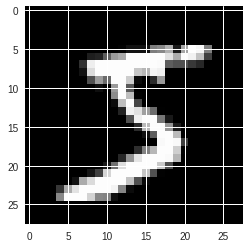

In [44]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

(X_train, _), (X_test, _) = mnist.load_data()

plt.imshow(X_train[0], cmap=plt.cm.gray)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

## Generator

Erstelle nun zuerst ein Model, welches aus einem Tensor mit den Dimensionen ```[batch_size, z_dim]``` einen Tensor mit den Dimensionen ```[batch_size, 28, 28, 1]``` generiert. ```28x28``` ist hierbei die Bildgröße der MNIST Daten, die Größe des Noisevektors (```z_dim```) kannst du selbst wählen. 

Sample nun eine Batch von Zufallswerten, z.b. aus einer Normalverteilung, und erstelle mit dem untrainierten Generator ein Batch von Bildern. Plotte diese generierten Bilder.

In [0]:
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import numpy as np

In [0]:
def plot_imgs(generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

In [47]:
z_dim = 32
batch_size = 64
img_rows = 28
img_cols = 28
channels = 1

noise_shape = (z_dim,)
img_shape = (img_rows, img_cols, channels)

print('X_train shape:', X_train.shape)

X_train shape: (60000, 28, 28)


In [48]:
dropout = 0.4

model = Sequential()
    
model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
model.add(Reshape((7, 7, 128)))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU())
model.add(UpSampling2D())
model.add(Dropout(dropout))

model.add(UpSampling2D())
model.add(Conv2D(64, 5, padding='same'))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU())

model.add(Conv2D(32, 5, padding='same'))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU())

model.add(Conv2D(1, 5, padding='same'))
model.add(Activation('tanh'))
    
model.summary()

noise = Input(shape=noise_shape)
img = model(noise)

generator = Model(noise, img)

adam = Adam(lr=0.0004, clipvalue=1.0, decay=1e-10)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 6272)              206976    
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 28, 28, 128)       0         
__________

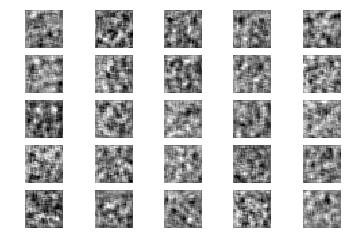

In [49]:
plot_imgs(generator)

## Discriminator

Erstelle nun ein Klassifizierungsnetzwerk, welchen mit dem Ausgabetensor des Generatornetzes (```[batch_size, 28, 28, 1]```) als Eingabe akzeptiert. Überprüfe, ob das Netzwerk die Ausgaben des Generators in Wahrscheinlichkeiten, also Werte zwischen 0 und 1, überführt.

In [50]:
model = Sequential()

dropout = 0.4

model.add(Conv2D(32, 3, strides=2, input_shape=img_shape, padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, strides=2, input_shape=img_shape, padding='same'))
model.add(LeakyReLU())

model.add(Conv2D(128, 3, strides=2, padding='same'))
model.add(LeakyReLU())
model.add(Dropout(dropout))

model.add(Conv2D(256, 3, strides=2, padding='same'))
model.add(LeakyReLU())
model.add(Dropout(dropout))

model.add(Conv2D(512, 3, strides=1, padding='same'))
model.add(LeakyReLU())
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

img = Input(shape=img_shape)
validity = model(img)

discriminator = Model(img, validity)

# RMSprop in the discriminator performs better that Adam. 
rmsprop = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-10)
discriminator.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 4, 4, 128)         0         
__________

In [52]:
noise = np.random.normal(0, 1, (batch_size, z_dim))
discriminator.predict(generator.predict(noise))

array([[0.50014   ],
       [0.499908  ],
       [0.49992687],
       [0.49988082],
       [0.5001275 ],
       [0.50011975],
       [0.49995506],
       [0.4998965 ],
       [0.49994904],
       [0.4998546 ],
       [0.50017804],
       [0.50004447],
       [0.4999174 ],
       [0.49988124],
       [0.5000316 ],
       [0.5001094 ],
       [0.49975145],
       [0.4998969 ],
       [0.5000903 ],
       [0.5000583 ],
       [0.4999926 ],
       [0.49972227],
       [0.50009656],
       [0.49976015],
       [0.4999659 ],
       [0.50011307],
       [0.4999212 ],
       [0.49986348],
       [0.5001024 ],
       [0.50005853],
       [0.4999962 ],
       [0.4999628 ],
       [0.49984914],
       [0.5002223 ],
       [0.4999891 ],
       [0.4998838 ],
       [0.500253  ],
       [0.5000698 ],
       [0.49994254],
       [0.49988464],
       [0.5000555 ],
       [0.5002022 ],
       [0.50018215],
       [0.4998085 ],
       [0.5000155 ],
       [0.5001302 ],
       [0.4999414 ],
       [0.500

## Training
Implementiere das Training des GANs wie in der Vorlesung besprochen. Gebe während des Trainings den Generator-Loss und den Discriminator-Loss aus. Am Ende des Trainings zeige einige vom Generator generierte Bilder (**RESULT**).

In [0]:
def train(epochs, batch_size, sample_interval):
    
    (X_train, _), (X_test, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    half_batch = int(batch_size / 2)
    batchCount = X_train.shape[0] / batch_size
    print('Epochs:', epochs)
    print('Batch size:', batch_size)
    print('Batches per epoch:', batchCount)
    print('---------------------------')
    
    # Disable all the layers of the descriminator in the generator model
    for layer in discriminator.layers:
        layer.trainable = False
    z = Input(shape=(z_dim,))
    img = generator(z)
    valid = discriminator(img)
    combined = Model(z, valid)
    combined.compile(loss='binary_crossentropy', optimizer=adam)
    
    for epoch in range(epochs):
        
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 32))
        gen_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        discriminator_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        discriminator_loss = 0.5 * np.add(d_loss_real, discriminator_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 32))
        valid_y = np.array([1] * batch_size)
        generator_loss = combined.train_on_batch(noise, valid_y)
        
        if epoch % sample_interval == 0:
            print ("-> Epoch: ", epoch, "\n", 
                   "  - Discriminator Loss: ", discriminator_loss, "\n",
                   "  - Generator Loss: ", generator_loss, "\n",
                   "  - Accuracy : ", 100*discriminator_loss[1])
            plot_generated_images(epoch)

            
def plot_generated_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 32))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    #fig.savefig("images/GANs/mnist_%d.png" % epoch)
    plt.show()

Epochs: 10000
Batch size: 32
Batches per epoch: 1875.0
---------------------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


-> Epoch:  0 
   - Discriminator Loss:  [0.50378966 0.78125   ] 
   - Generator Loss:  1.3041581 
   - Accuracy :  78.125


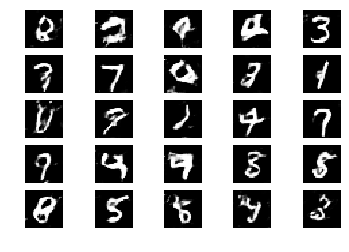

-> Epoch:  100 
   - Discriminator Loss:  [0.69316316 0.625     ] 
   - Generator Loss:  1.6694717 
   - Accuracy :  62.5


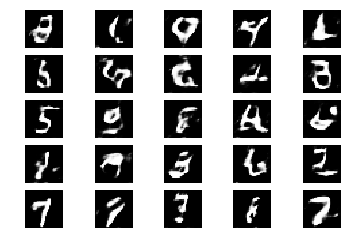

-> Epoch:  200 
   - Discriminator Loss:  [0.42939055 0.8125    ] 
   - Generator Loss:  1.5005467 
   - Accuracy :  81.25


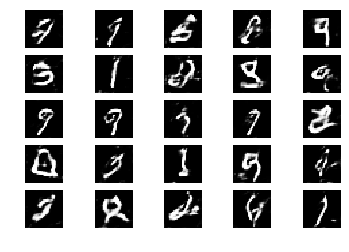

-> Epoch:  300 
   - Discriminator Loss:  [0.7889086 0.5625   ] 
   - Generator Loss:  1.9269859 
   - Accuracy :  56.25


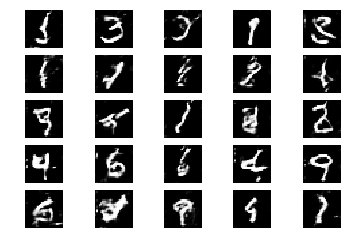

-> Epoch:  400 
   - Discriminator Loss:  [0.5678262 0.78125  ] 
   - Generator Loss:  1.5705014 
   - Accuracy :  78.125


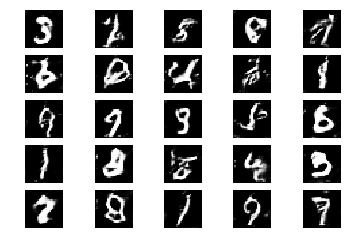

-> Epoch:  500 
   - Discriminator Loss:  [0.57458794 0.65625   ] 
   - Generator Loss:  1.032727 
   - Accuracy :  65.625


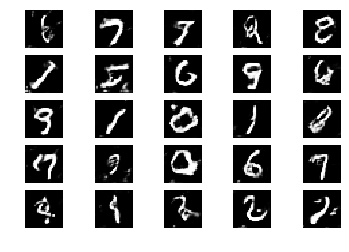

-> Epoch:  600 
   - Discriminator Loss:  [0.56793493 0.75      ] 
   - Generator Loss:  1.4419006 
   - Accuracy :  75.0


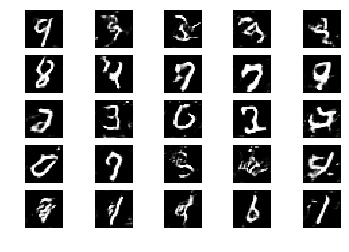

-> Epoch:  700 
   - Discriminator Loss:  [0.53365314 0.6875    ] 
   - Generator Loss:  1.466407 
   - Accuracy :  68.75


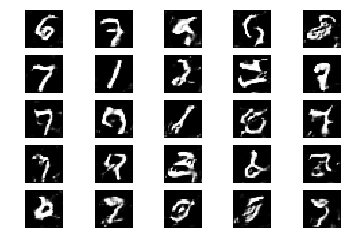

-> Epoch:  800 
   - Discriminator Loss:  [0.611897 0.625   ] 
   - Generator Loss:  1.4564879 
   - Accuracy :  62.5


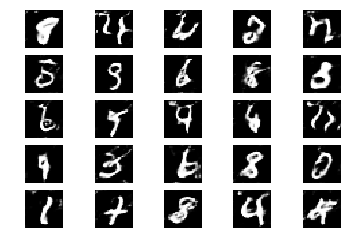

-> Epoch:  900 
   - Discriminator Loss:  [0.6113056 0.625    ] 
   - Generator Loss:  1.2829797 
   - Accuracy :  62.5


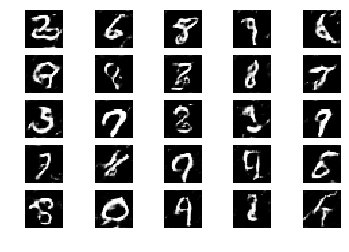

-> Epoch:  1000 
   - Discriminator Loss:  [0.72211426 0.5625    ] 
   - Generator Loss:  1.345841 
   - Accuracy :  56.25


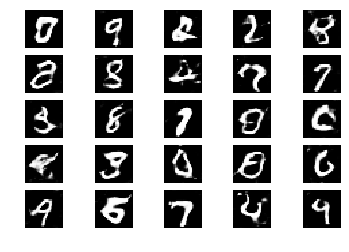

-> Epoch:  1100 
   - Discriminator Loss:  [0.6193282 0.6875   ] 
   - Generator Loss:  1.3831567 
   - Accuracy :  68.75


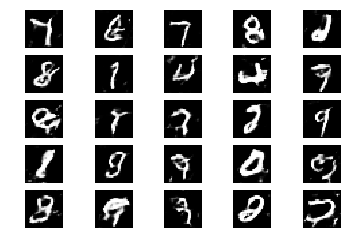

-> Epoch:  1200 
   - Discriminator Loss:  [0.42782763 0.78125   ] 
   - Generator Loss:  1.1002625 
   - Accuracy :  78.125


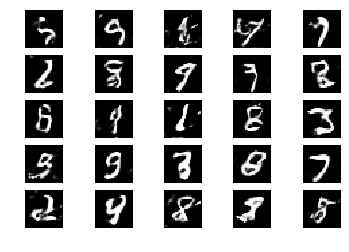

-> Epoch:  1300 
   - Discriminator Loss:  [0.6913737 0.59375  ] 
   - Generator Loss:  1.1949372 
   - Accuracy :  59.375


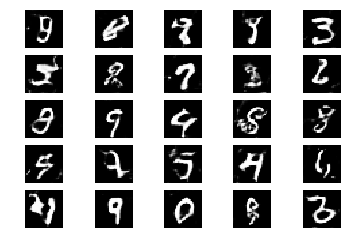

-> Epoch:  1400 
   - Discriminator Loss:  [0.52431846 0.75      ] 
   - Generator Loss:  1.1703665 
   - Accuracy :  75.0


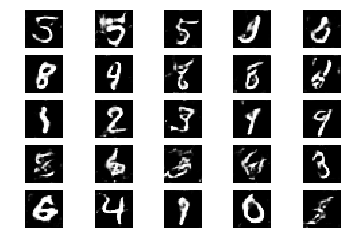

-> Epoch:  1500 
   - Discriminator Loss:  [0.68782836 0.59375   ] 
   - Generator Loss:  1.3944008 
   - Accuracy :  59.375


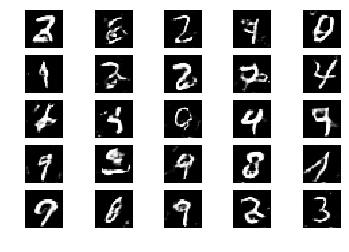

-> Epoch:  1600 
   - Discriminator Loss:  [0.58708405 0.65625   ] 
   - Generator Loss:  1.1835663 
   - Accuracy :  65.625


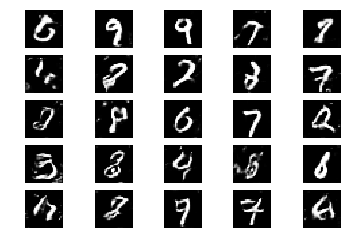

-> Epoch:  1700 
   - Discriminator Loss:  [0.5419677 0.84375  ] 
   - Generator Loss:  1.1541889 
   - Accuracy :  84.375


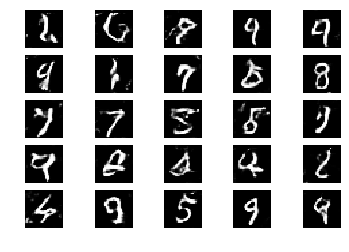

-> Epoch:  1800 
   - Discriminator Loss:  [0.6006506 0.625    ] 
   - Generator Loss:  1.2793784 
   - Accuracy :  62.5


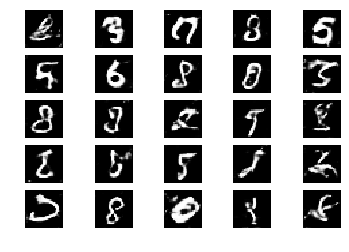

-> Epoch:  1900 
   - Discriminator Loss:  [0.77073646 0.59375   ] 
   - Generator Loss:  1.0144359 
   - Accuracy :  59.375


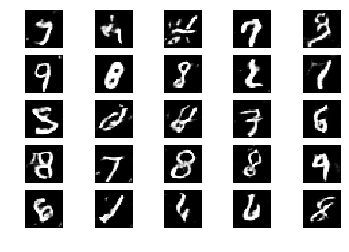

-> Epoch:  2000 
   - Discriminator Loss:  [0.62226295 0.59375   ] 
   - Generator Loss:  1.3546677 
   - Accuracy :  59.375


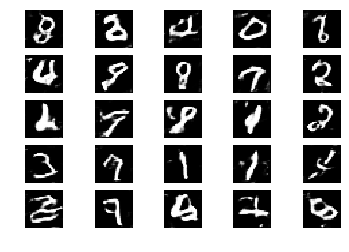

-> Epoch:  2100 
   - Discriminator Loss:  [0.7950404 0.5625   ] 
   - Generator Loss:  1.204847 
   - Accuracy :  56.25


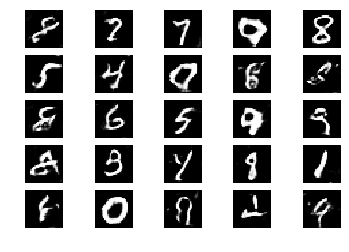

-> Epoch:  2200 
   - Discriminator Loss:  [0.5755588 0.6875   ] 
   - Generator Loss:  1.127526 
   - Accuracy :  68.75


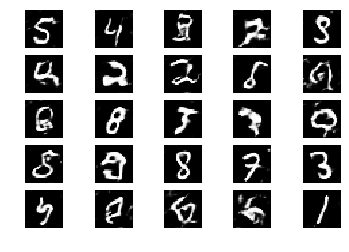

-> Epoch:  2300 
   - Discriminator Loss:  [0.65171415 0.5625    ] 
   - Generator Loss:  1.0649726 
   - Accuracy :  56.25


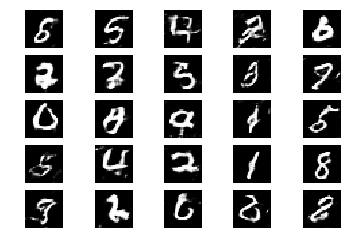

-> Epoch:  2400 
   - Discriminator Loss:  [0.55670714 0.65625   ] 
   - Generator Loss:  1.2015402 
   - Accuracy :  65.625


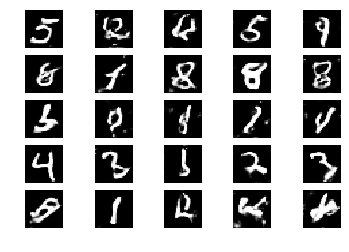

-> Epoch:  2500 
   - Discriminator Loss:  [0.7099467 0.59375  ] 
   - Generator Loss:  1.1759803 
   - Accuracy :  59.375


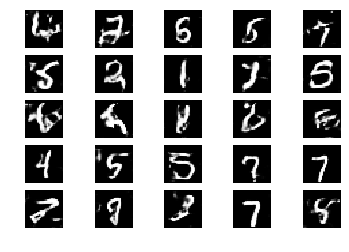

-> Epoch:  2600 
   - Discriminator Loss:  [0.6348742 0.59375  ] 
   - Generator Loss:  1.047646 
   - Accuracy :  59.375


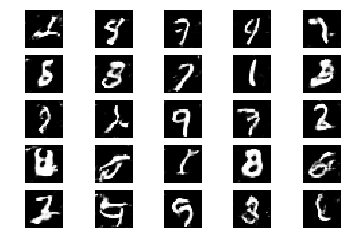

-> Epoch:  2700 
   - Discriminator Loss:  [0.6296893 0.625    ] 
   - Generator Loss:  1.0636587 
   - Accuracy :  62.5


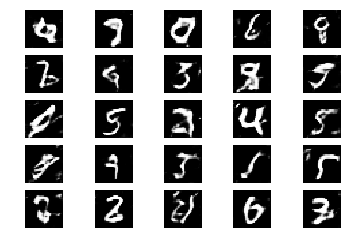

-> Epoch:  2800 
   - Discriminator Loss:  [0.70358896 0.625     ] 
   - Generator Loss:  1.2050873 
   - Accuracy :  62.5


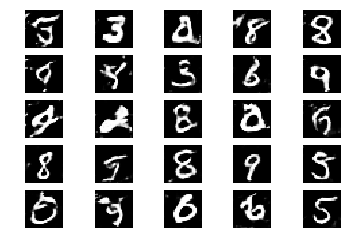

-> Epoch:  2900 
   - Discriminator Loss:  [0.5412785 0.71875  ] 
   - Generator Loss:  1.3079293 
   - Accuracy :  71.875


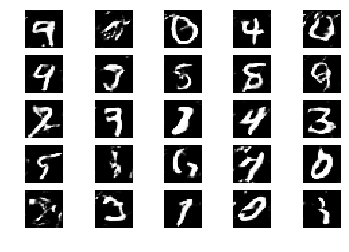

-> Epoch:  3000 
   - Discriminator Loss:  [0.8075754 0.5      ] 
   - Generator Loss:  1.2769527 
   - Accuracy :  50.0


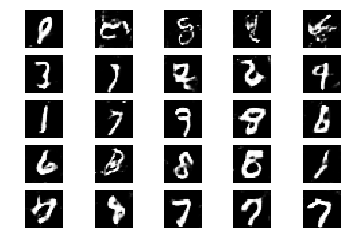

-> Epoch:  3100 
   - Discriminator Loss:  [0.64301264 0.65625   ] 
   - Generator Loss:  1.0658784 
   - Accuracy :  65.625


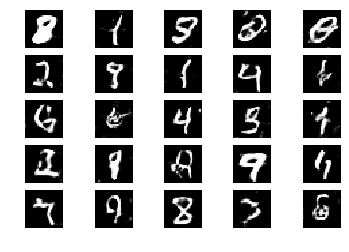

-> Epoch:  3200 
   - Discriminator Loss:  [0.9689003 0.40625  ] 
   - Generator Loss:  1.292222 
   - Accuracy :  40.625


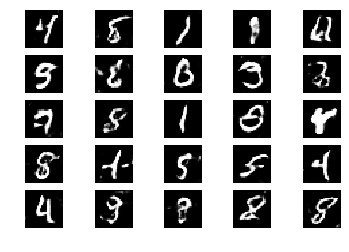

-> Epoch:  3300 
   - Discriminator Loss:  [0.6325878 0.59375  ] 
   - Generator Loss:  1.3773308 
   - Accuracy :  59.375


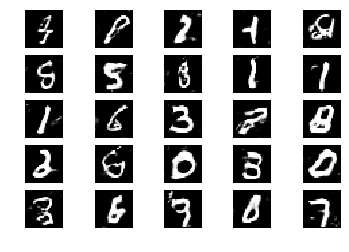

-> Epoch:  3400 
   - Discriminator Loss:  [0.5412699 0.71875  ] 
   - Generator Loss:  1.3461394 
   - Accuracy :  71.875


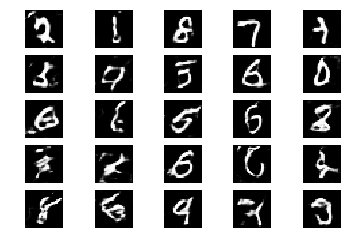

-> Epoch:  3500 
   - Discriminator Loss:  [0.48609853 0.8125    ] 
   - Generator Loss:  1.4216266 
   - Accuracy :  81.25


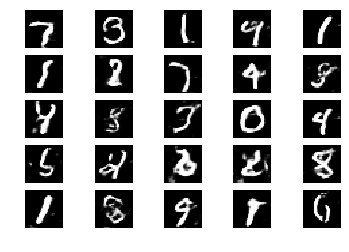

-> Epoch:  3600 
   - Discriminator Loss:  [0.59339124 0.6875    ] 
   - Generator Loss:  1.1611898 
   - Accuracy :  68.75


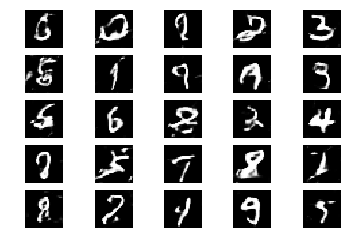

-> Epoch:  3700 
   - Discriminator Loss:  [0.51370054 0.8125    ] 
   - Generator Loss:  1.0433837 
   - Accuracy :  81.25


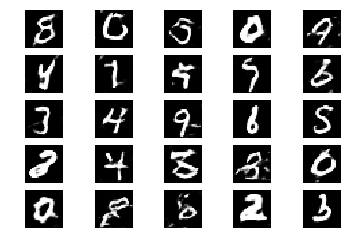

-> Epoch:  3800 
   - Discriminator Loss:  [0.5559622 0.625    ] 
   - Generator Loss:  0.9651783 
   - Accuracy :  62.5


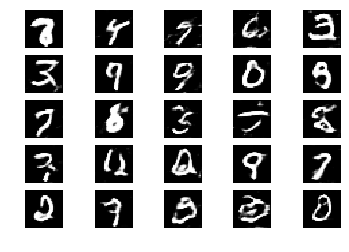

-> Epoch:  3900 
   - Discriminator Loss:  [0.59568983 0.65625   ] 
   - Generator Loss:  0.9734418 
   - Accuracy :  65.625


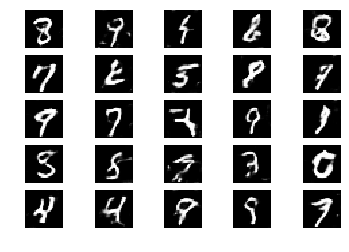

-> Epoch:  4000 
   - Discriminator Loss:  [0.5893874 0.71875  ] 
   - Generator Loss:  1.2490715 
   - Accuracy :  71.875


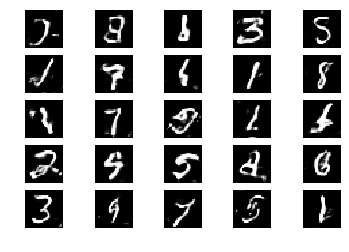

-> Epoch:  4100 
   - Discriminator Loss:  [0.59311986 0.71875   ] 
   - Generator Loss:  0.75974214 
   - Accuracy :  71.875


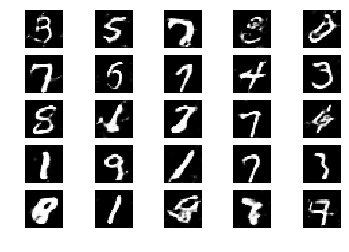

-> Epoch:  4200 
   - Discriminator Loss:  [0.5278356 0.71875  ] 
   - Generator Loss:  1.117604 
   - Accuracy :  71.875


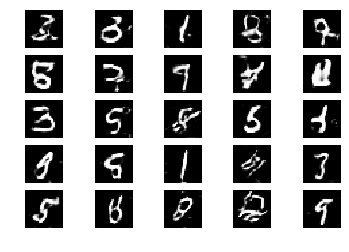

-> Epoch:  4300 
   - Discriminator Loss:  [0.52241147 0.78125   ] 
   - Generator Loss:  1.1282997 
   - Accuracy :  78.125


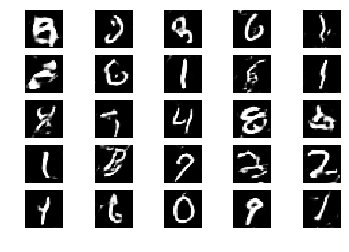

-> Epoch:  4400 
   - Discriminator Loss:  [0.61215854 0.65625   ] 
   - Generator Loss:  1.030299 
   - Accuracy :  65.625


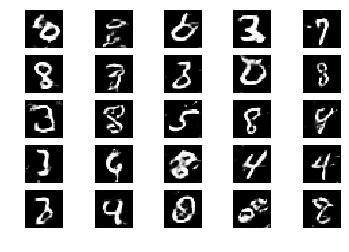

-> Epoch:  4500 
   - Discriminator Loss:  [0.6717032 0.5625   ] 
   - Generator Loss:  0.9812246 
   - Accuracy :  56.25


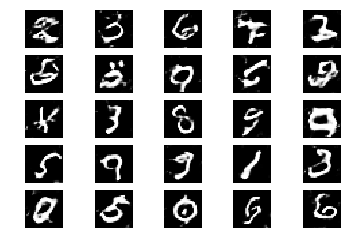

-> Epoch:  4600 
   - Discriminator Loss:  [0.60213995 0.625     ] 
   - Generator Loss:  0.755941 
   - Accuracy :  62.5


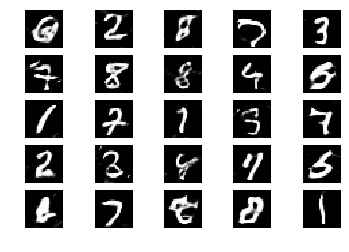

-> Epoch:  4700 
   - Discriminator Loss:  [0.8943281 0.46875  ] 
   - Generator Loss:  1.0049462 
   - Accuracy :  46.875


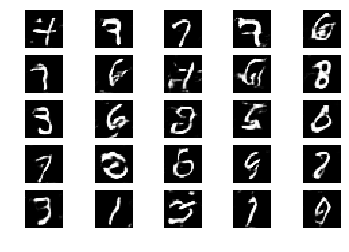

-> Epoch:  4800 
   - Discriminator Loss:  [0.652643 0.59375 ] 
   - Generator Loss:  0.9737453 
   - Accuracy :  59.375


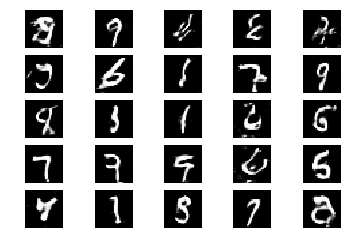

-> Epoch:  4900 
   - Discriminator Loss:  [0.8250704 0.5625   ] 
   - Generator Loss:  0.9488609 
   - Accuracy :  56.25


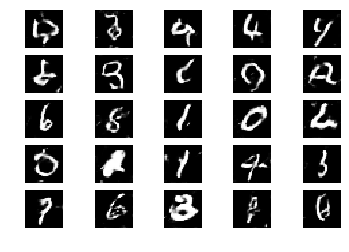

-> Epoch:  5000 
   - Discriminator Loss:  [0.7179891 0.5625   ] 
   - Generator Loss:  1.2279415 
   - Accuracy :  56.25


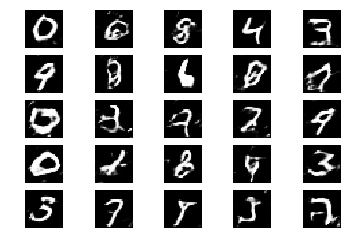

-> Epoch:  5100 
   - Discriminator Loss:  [0.8089143 0.59375  ] 
   - Generator Loss:  1.2125896 
   - Accuracy :  59.375


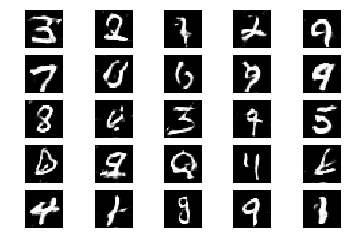

-> Epoch:  5200 
   - Discriminator Loss:  [0.7542658 0.59375  ] 
   - Generator Loss:  0.8730898 
   - Accuracy :  59.375


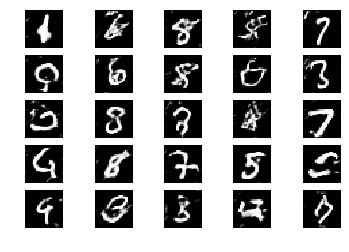

-> Epoch:  5300 
   - Discriminator Loss:  [0.53241616 0.71875   ] 
   - Generator Loss:  0.94476455 
   - Accuracy :  71.875


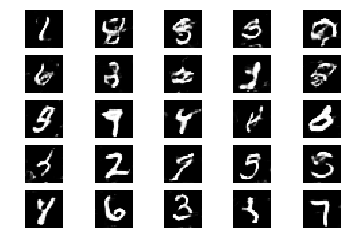

-> Epoch:  5400 
   - Discriminator Loss:  [0.71363264 0.5625    ] 
   - Generator Loss:  1.0037551 
   - Accuracy :  56.25


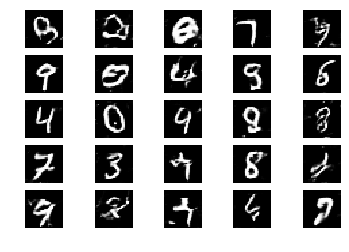

-> Epoch:  5500 
   - Discriminator Loss:  [0.66695285 0.625     ] 
   - Generator Loss:  1.2608814 
   - Accuracy :  62.5


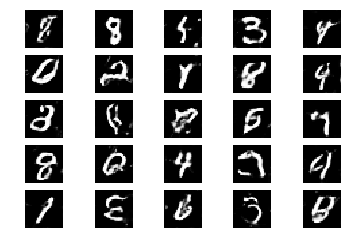

-> Epoch:  5600 
   - Discriminator Loss:  [0.62204653 0.65625   ] 
   - Generator Loss:  1.1070257 
   - Accuracy :  65.625


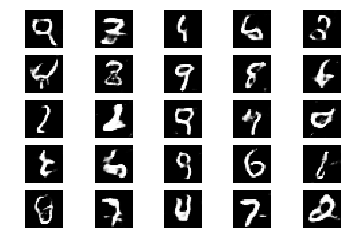

-> Epoch:  5700 
   - Discriminator Loss:  [0.5403122 0.71875  ] 
   - Generator Loss:  1.0844002 
   - Accuracy :  71.875


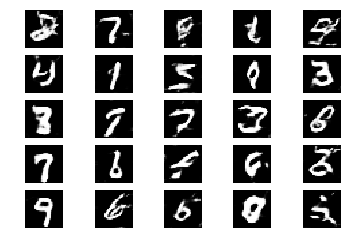

-> Epoch:  5800 
   - Discriminator Loss:  [0.57507783 0.75      ] 
   - Generator Loss:  1.0501245 
   - Accuracy :  75.0


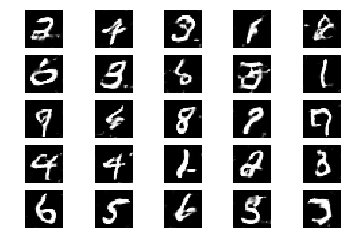

-> Epoch:  5900 
   - Discriminator Loss:  [0.52705026 0.71875   ] 
   - Generator Loss:  0.992435 
   - Accuracy :  71.875


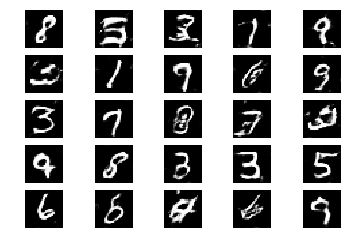

-> Epoch:  6000 
   - Discriminator Loss:  [0.6189859 0.65625  ] 
   - Generator Loss:  0.90684533 
   - Accuracy :  65.625


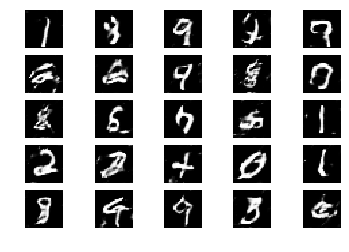

-> Epoch:  6100 
   - Discriminator Loss:  [0.6228684 0.6875   ] 
   - Generator Loss:  1.1982422 
   - Accuracy :  68.75


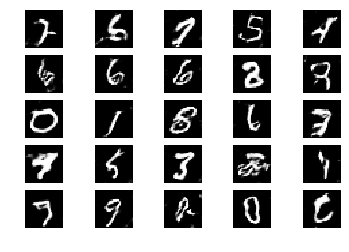

-> Epoch:  6200 
   - Discriminator Loss:  [0.7386706 0.46875  ] 
   - Generator Loss:  0.89391506 
   - Accuracy :  46.875


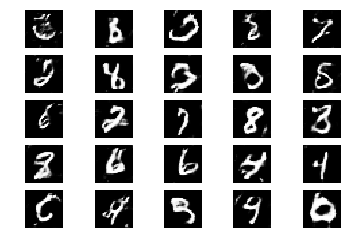

-> Epoch:  6300 
   - Discriminator Loss:  [0.5243248 0.75     ] 
   - Generator Loss:  1.67234 
   - Accuracy :  75.0


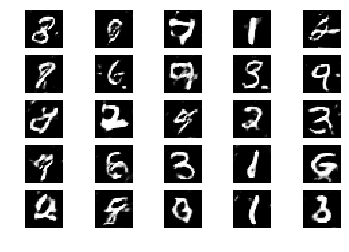

-> Epoch:  6400 
   - Discriminator Loss:  [0.68998134 0.625     ] 
   - Generator Loss:  0.6597321 
   - Accuracy :  62.5


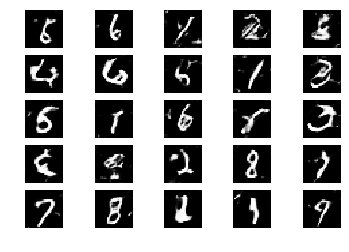

-> Epoch:  6500 
   - Discriminator Loss:  [0.5385709 0.65625  ] 
   - Generator Loss:  1.32977 
   - Accuracy :  65.625


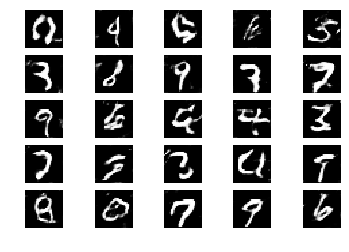

-> Epoch:  6600 
   - Discriminator Loss:  [0.60717887 0.6875    ] 
   - Generator Loss:  0.60652006 
   - Accuracy :  68.75


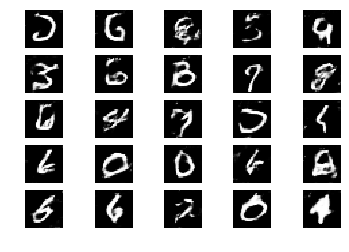

-> Epoch:  6700 
   - Discriminator Loss:  [0.39137957 0.84375   ] 
   - Generator Loss:  1.0037307 
   - Accuracy :  84.375


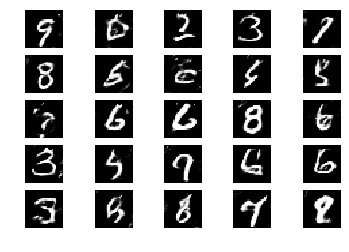

-> Epoch:  6800 
   - Discriminator Loss:  [0.6880836 0.625    ] 
   - Generator Loss:  2.4023418 
   - Accuracy :  62.5


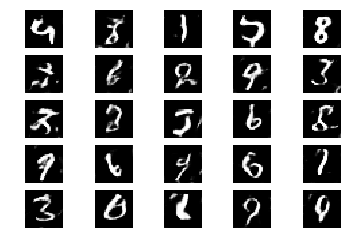

-> Epoch:  6900 
   - Discriminator Loss:  [0.5548773 0.65625  ] 
   - Generator Loss:  1.8344496 
   - Accuracy :  65.625


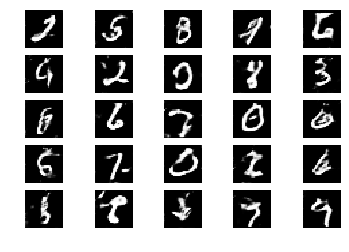

-> Epoch:  7000 
   - Discriminator Loss:  [0.86020887 0.59375   ] 
   - Generator Loss:  1.0557015 
   - Accuracy :  59.375


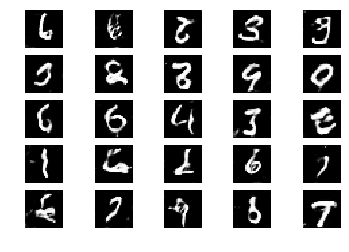

-> Epoch:  7100 
   - Discriminator Loss:  [0.51075476 0.71875   ] 
   - Generator Loss:  1.0518844 
   - Accuracy :  71.875


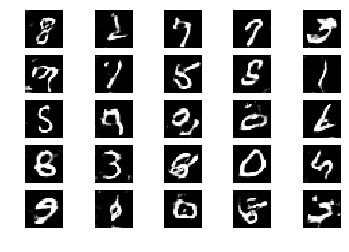

-> Epoch:  7200 
   - Discriminator Loss:  [0.6435604 0.625    ] 
   - Generator Loss:  0.7499713 
   - Accuracy :  62.5


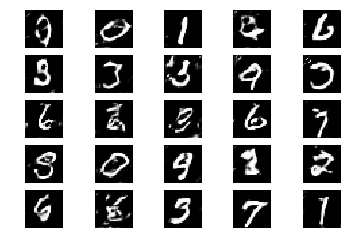

-> Epoch:  7300 
   - Discriminator Loss:  [0.6625675 0.59375  ] 
   - Generator Loss:  0.35753262 
   - Accuracy :  59.375


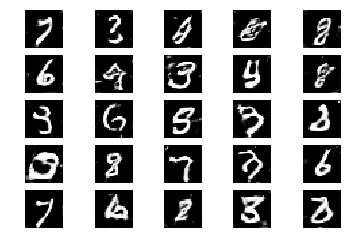

-> Epoch:  7400 
   - Discriminator Loss:  [0.5423545 0.8125   ] 
   - Generator Loss:  1.1213027 
   - Accuracy :  81.25


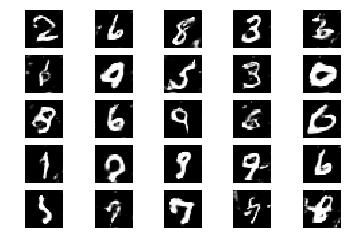

-> Epoch:  7500 
   - Discriminator Loss:  [0.6929628 0.59375  ] 
   - Generator Loss:  1.7276592 
   - Accuracy :  59.375


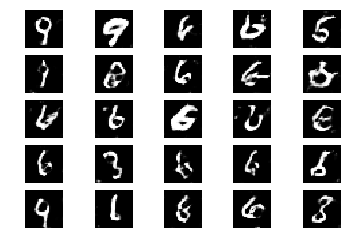

-> Epoch:  7600 
   - Discriminator Loss:  [0.4609877 0.71875  ] 
   - Generator Loss:  1.7899555 
   - Accuracy :  71.875


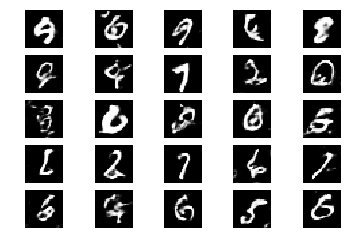

-> Epoch:  7700 
   - Discriminator Loss:  [0.64019716 0.65625   ] 
   - Generator Loss:  1.7410715 
   - Accuracy :  65.625


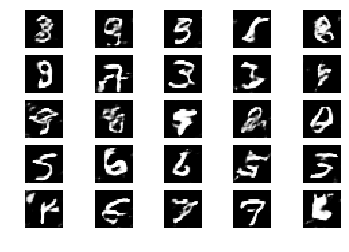

-> Epoch:  7800 
   - Discriminator Loss:  [0.36910433 0.78125   ] 
   - Generator Loss:  1.0716558 
   - Accuracy :  78.125


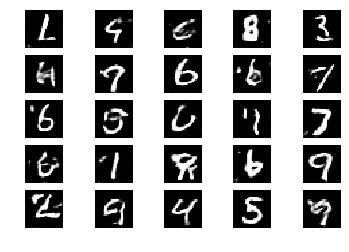

-> Epoch:  7900 
   - Discriminator Loss:  [0.6596816 0.8125   ] 
   - Generator Loss:  1.5763061 
   - Accuracy :  81.25


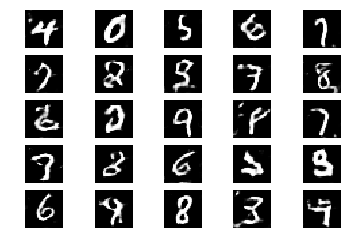

-> Epoch:  8000 
   - Discriminator Loss:  [0.4698252 0.75     ] 
   - Generator Loss:  1.131886 
   - Accuracy :  75.0


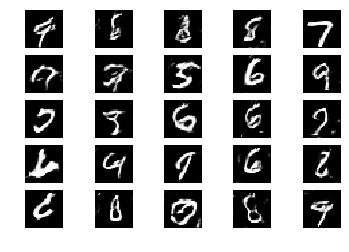

-> Epoch:  8100 
   - Discriminator Loss:  [0.45132387 0.78125   ] 
   - Generator Loss:  0.88081 
   - Accuracy :  78.125


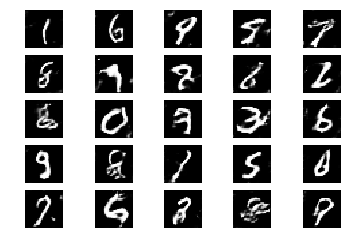

-> Epoch:  8200 
   - Discriminator Loss:  [0.6418547 0.6875   ] 
   - Generator Loss:  1.1473203 
   - Accuracy :  68.75


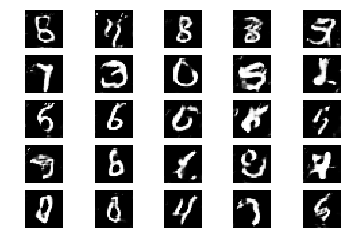

-> Epoch:  8300 
   - Discriminator Loss:  [0.49249476 0.78125   ] 
   - Generator Loss:  0.7896507 
   - Accuracy :  78.125


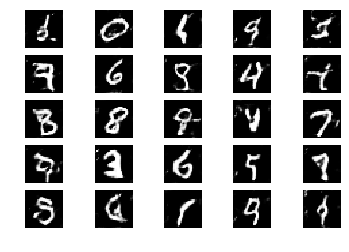

-> Epoch:  8400 
   - Discriminator Loss:  [0.8252431 0.625    ] 
   - Generator Loss:  0.8569304 
   - Accuracy :  62.5


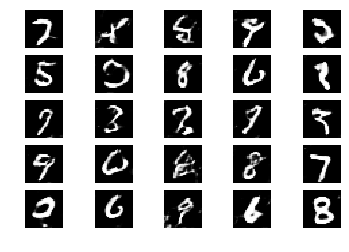

-> Epoch:  8500 
   - Discriminator Loss:  [0.63447297 0.625     ] 
   - Generator Loss:  0.8688718 
   - Accuracy :  62.5


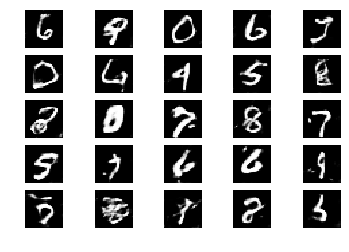

-> Epoch:  8600 
   - Discriminator Loss:  [0.51048845 0.75      ] 
   - Generator Loss:  1.8198105 
   - Accuracy :  75.0


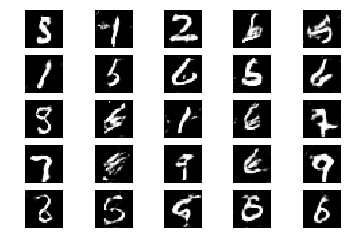

-> Epoch:  8700 
   - Discriminator Loss:  [0.3582496 0.8125   ] 
   - Generator Loss:  0.92720896 
   - Accuracy :  81.25


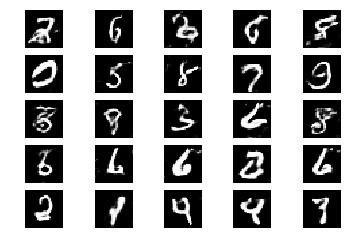

-> Epoch:  8800 
   - Discriminator Loss:  [0.4433415 0.78125  ] 
   - Generator Loss:  1.2053868 
   - Accuracy :  78.125


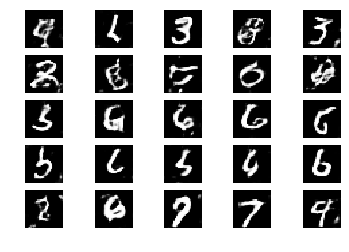

-> Epoch:  8900 
   - Discriminator Loss:  [0.6020037 0.6875   ] 
   - Generator Loss:  1.0870064 
   - Accuracy :  68.75


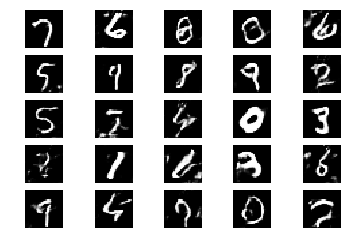

-> Epoch:  9000 
   - Discriminator Loss:  [0.4943509 0.71875  ] 
   - Generator Loss:  1.2335713 
   - Accuracy :  71.875


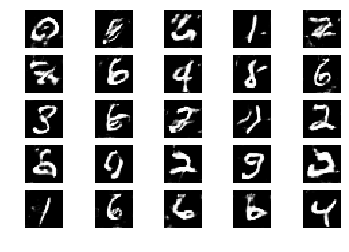

-> Epoch:  9100 
   - Discriminator Loss:  [0.6794258 0.625    ] 
   - Generator Loss:  1.1800969 
   - Accuracy :  62.5


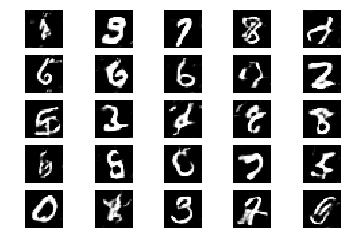

-> Epoch:  9200 
   - Discriminator Loss:  [0.5679909 0.65625  ] 
   - Generator Loss:  1.3896528 
   - Accuracy :  65.625


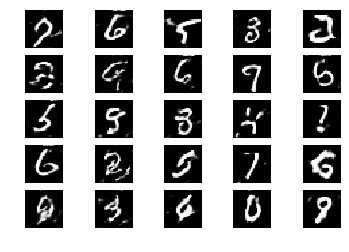

-> Epoch:  9300 
   - Discriminator Loss:  [0.5283421 0.75     ] 
   - Generator Loss:  2.4180212 
   - Accuracy :  75.0


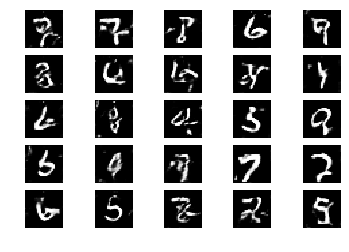

-> Epoch:  9400 
   - Discriminator Loss:  [0.42339593 0.84375   ] 
   - Generator Loss:  0.7692052 
   - Accuracy :  84.375


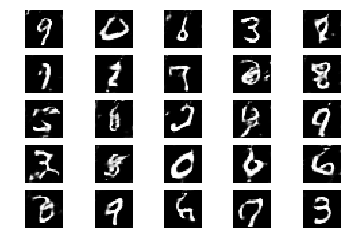

-> Epoch:  9500 
   - Discriminator Loss:  [0.7046946 0.625    ] 
   - Generator Loss:  1.6906693 
   - Accuracy :  62.5


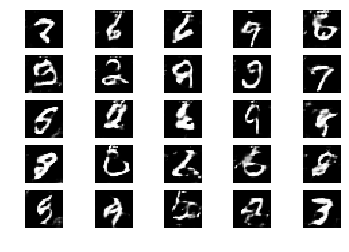

-> Epoch:  9600 
   - Discriminator Loss:  [0.4127912 0.875    ] 
   - Generator Loss:  1.2198766 
   - Accuracy :  87.5


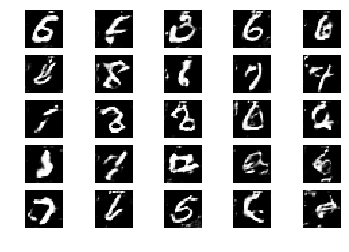

-> Epoch:  9700 
   - Discriminator Loss:  [0.605286 0.625   ] 
   - Generator Loss:  1.6312897 
   - Accuracy :  62.5


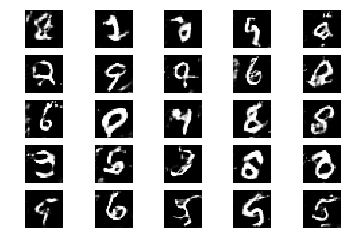

-> Epoch:  9800 
   - Discriminator Loss:  [0.5364398 0.75     ] 
   - Generator Loss:  1.469847 
   - Accuracy :  75.0


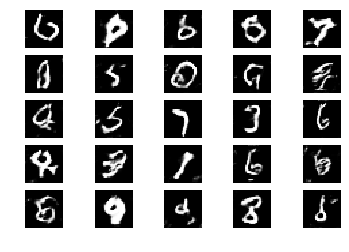

-> Epoch:  9900 
   - Discriminator Loss:  [0.5746083 0.625    ] 
   - Generator Loss:  1.2938482 
   - Accuracy :  62.5


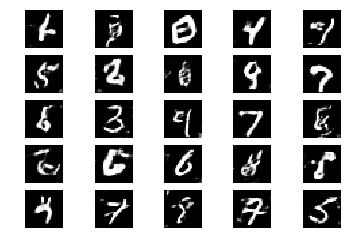

In [59]:
train(epochs=10000, batch_size=32, sample_interval=100)